In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder, StandardScaler
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

In [103]:
df = pd.read_csv('/content/quikr_car.csv')
df.sample(5)

,name,company,year,Price,kms_driven,fuel_type
450,Mahindra Scorpio S10,Mahindra,2015,"9,00,000","97,200 kms",Diesel
315,Honda City,Honda,2015,"6,44,999","39,000 kms",Petrol
717,Maruti Suzuki Wagon R LXi BS III,Maruti,2014,"1,30,000","37,458 kms",Petrol
554,BMW X1 xDrive20d xLine,BMW,2011,"11,50,000","72,000 kms",Diesel
159,Maruti Suzuki Swift RS VDI,Maruti,2010,"1,89,500","38,500 kms",Diesel


In [104]:
df.shape

(892, 6)

In [105]:
df.isna().sum()

,0
name,0
company,0
year,0
Price,0
kms_driven,52
fuel_type,55


# Bringing cols in proper format and dropping unnecessary


In [106]:
df['Price'] = df['Price'].apply(lambda x: x.replace(',',''))

In [107]:
df = df[df['Price'].str.isdigit()]

In [108]:
df['Price'] = df['Price'].astype(int)

In [109]:
df.shape

(857, 6)

In [110]:
df = df[df['kms_driven'] != 'Petrol']

In [111]:
df = df[df['kms_driven'].notna()]

In [112]:
df['kms_driven'] = df['kms_driven'].apply(lambda x: x.split(' ')[0].replace(',',''))

In [113]:
df['kms_driven'] = df['kms_driven'].astype(int)

In [114]:
df = df[df['fuel_type'].notna()]

In [115]:
df.shape

(816, 6)

In [116]:
df['year'] = df['year'].astype(int)

In [117]:
df['company'].nunique()

25

In [118]:
df['name'] = df['name'].apply(lambda x : ' '.join((x.split(' ')[1:3])))

In [119]:
df['name'].nunique()

254

In [120]:
df[df['company']=='Tata']

,name,company,year,Price,kms_driven,fuel_type
62,Indigo eCS,Tata,2017,200000,130000,Diesel
64,Indigo eCS,Tata,2017,200000,130000,Diesel
137,Indica V2,Tata,2006,90000,20000,Petrol
169,Indigo CS,Tata,2011,85000,11400,Diesel
183,Indigo eCS,Tata,2016,320000,175430,Diesel
...,...,...,...,...,...,...
864,Indica eV2,Tata,2016,50500,91200,Diesel
866,Zest XE,Tata,2017,290000,120000,Diesel
868,Indigo eCS,Tata,2016,160000,104000,Diesel
885,Indica V2,Tata,2009,110000,30000,Diesel


In [121]:
df.drop_duplicates(inplace=True)

In [122]:
df['name'].nunique()

254

In [123]:
df['company'].value_counts()

,count
company,
Maruti,199
Hyundai,129
Mahindra,78
Tata,61
Honda,51
Toyota,34
Chevrolet,33
Renault,26
Ford,26


In [124]:
df.describe()

,year,Price,kms_driven
count,720.000000,7.200000e+02,720.000000
mean,2012.325000,4.021574e+05,46787.397222
std,4.132363,4.781514e+05,34609.808464
min,1995.000000,3.000000e+04,0.000000
25%,2010.000000,1.672500e+05,27000.000000
50%,2013.000000,2.900000e+05,42000.000000
75%,2015.000000,4.899990e+05,59000.000000
max,2019.000000,8.500003e+06,400000.000000


In [125]:
threshold = df['Price'].quantile(0.90)
print(threshold)
df = df[df['Price'] <= threshold]

750000.0


In [126]:
df = df[df['kms_driven']<=350000]

<Axes: ylabel='kms_driven'>

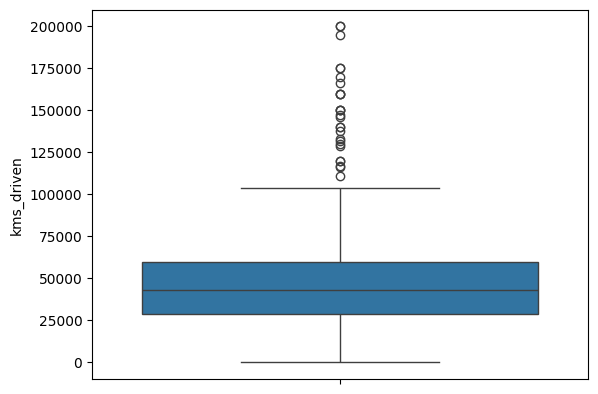

In [127]:
sns.boxplot(df['kms_driven'])

<Axes: xlabel='kms_driven', ylabel='Density'>

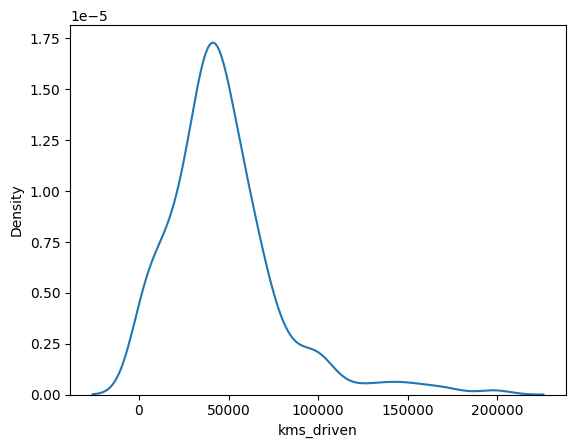

In [128]:
sns.kdeplot(df['kms_driven'])

# outlier handling

In [129]:
p25 = df['kms_driven'].quantile(0.25)
p75 = df['kms_driven'].quantile(0.75)
iqr = p75 - p25
upper_lim = p75 + 1.5*iqr
lower_lim = p25 - 1.5*iqr
df['kms_driven'] = np.where(df['kms_driven']>upper_lim,upper_lim,
                            np.where(df['kms_driven']<lower_lim,lower_lim,df['kms_driven']))

<Axes: ylabel='kms_driven'>

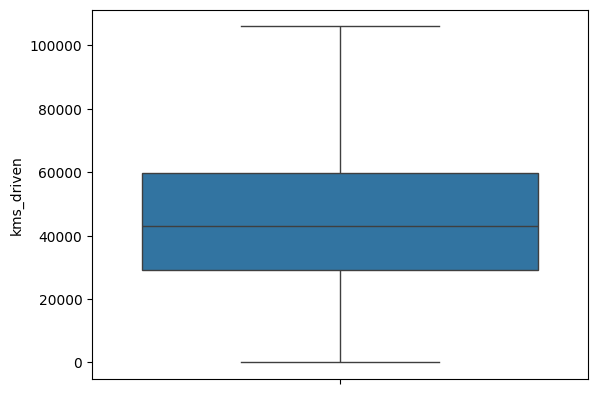

In [130]:
sns.boxplot(df['kms_driven'])

<Axes: xlabel='kms_driven', ylabel='Density'>

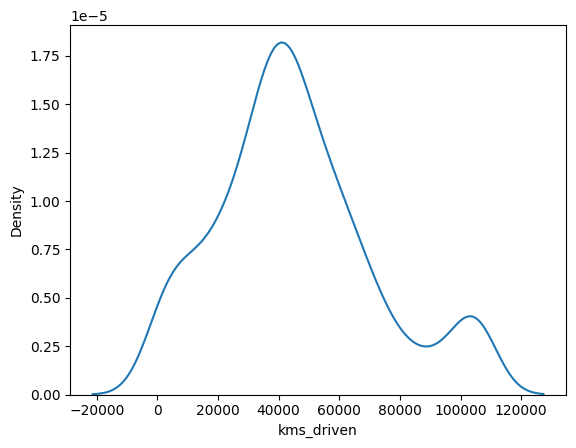

In [131]:
sns.kdeplot(df['kms_driven'])

In [239]:
df.to_csv('car_cleaned_dataset')

In [225]:
X_train,X_test,y_train,y_test = train_test_split(df.drop('Price',axis=1),df['Price'],test_size=0.2,random_state=135)

In [226]:
X_train['fuel_type'].unique()

array(['Diesel', 'Petrol', 'LPG'], dtype=object)

In [227]:
for idx,val in enumerate(X_train.columns):
    print(idx,val)

0 name
1 company
2 year
3 kms_driven
4 fuel_type


In [228]:
preprocess = ColumnTransformer(transformers=[
    ('ohe',OneHotEncoder(drop='first',sparse_output=False,handle_unknown='ignore',dtype=np.int32),[0,1,4]),
    ('scaler',StandardScaler(),[2,3])
],remainder='passthrough')

In [229]:
model = LinearRegression()

In [230]:
pipe = Pipeline([
    ('preprocess',preprocess),
    ('model',model)
])
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                dtype=<class 'numpy.int32'>,
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [0, 1, 4]),
                                                 ('scaler', StandardScaler(),
                                                  [2, 3])])),
                ('model', LinearRegression())])

In [231]:
y_pred = pipe.predict(X_test)
r2_score(y_test,y_pred)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.7092884669872909

In [232]:
cross_val_score(pipe,X_train,y_train,cv=3,n_jobs=-1,scoring='r2').mean()

np.float64(0.6296081586689899)

In [235]:
X_test.iloc[5].values

array(['Suzuki Zen', 'Maruti', np.int64(2004), np.float64(56000.0),
       'Petrol'], dtype=object)

In [238]:
y_test.iloc[5]

np.int64(68000)

In [237]:
pipe.predict([X_test.iloc[5].values])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([67196.35108184])

In [240]:
import joblib
joblib.dump(pipe,'car_model.pkl')

['car_model.pkl']

In [212]:
# train_score = []
# test_score = []
# for i in range(1000):
#     X_train,X_test,y_train,y_test = train_test_split(df.drop('Price',axis=1),df['Price'],test_size=0.2,random_state=i)
#     pipe = Pipeline([
#         ('preprocess',preprocess),
#         # ('pca',pca),
#         ('model',model)
#     ])
#     pipe.fit(X_train,y_train)
#     test_score.append(pipe.score(X_test,y_test))
#     train_score.append(cross_val_score(pipe,X_train,y_train,cv=3,n_jobs=-1).mean())

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categ

In [213]:
print(np.argmax(train_score))
print(np.argmax(test_score))

689
473


In [214]:
print(np.max(train_score))
print(np.max(test_score))

0.7320346027567299
0.8013501644681861


In [224]:
max_test_score = []
for i in range(len(train_score)):
    if test_score[i]>=0.70 and train_score[i]>=0.61:
        print(i,'=',train_score[i])
        # max_test_score.append(train_score[i])

48 = 0.6172458385863974
135 = 0.6296081586689899
505 = 0.6105950087705297
724 = 0.6239309212824481
764 = 0.6198825534263654
